In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import os
print(os.listdir('C:/Users/Durga/project/Handwritten Recognition/M2'))

['.ipynb_checkpoints', 'DIGITS JPG', 'hand written.ipynb', 'Model', 'test_the_model.ipynb', 'train.csv', 'training_1']


In [3]:
data = pd.read_csv("C:/Users/Durga/project/Handwritten Recognition/M2/train.csv")

In [4]:
data.shape

(42000, 785)

In [5]:
data.isnull().sum().sum()

0

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [7]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X = data.drop("label",axis=1)

In [9]:
Y = data["label"]

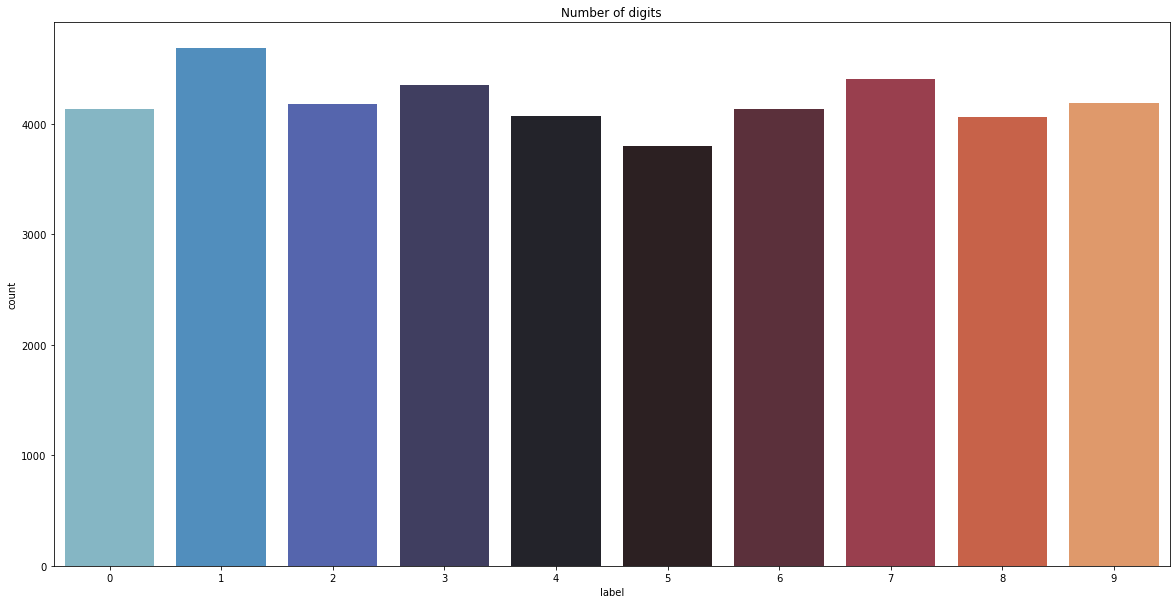

In [10]:
plt.figure(figsize=(20,10))
sns.countplot(Y,palette="icefire")
plt.title("Number of digits")
plt.show()

In [11]:
Y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

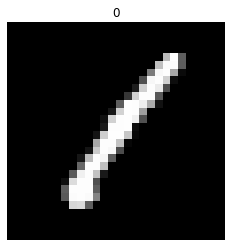

In [12]:
img = X.iloc[0].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(X.iloc[0,0])
plt.axis("off")
plt.show()

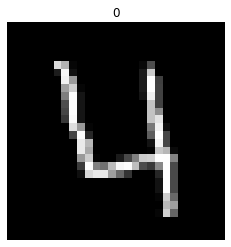

In [13]:
img = X.iloc[3].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(X.iloc[3,0])
plt.axis("off")
plt.show()

In [14]:
# Normalize the data
X = X / 255.0
print("x shape: ",X.shape)


x shape:  (42000, 784)


In [15]:
X = X.to_numpy()

In [16]:
# Reshape
X = X.reshape(-1,28,28,1)

In [17]:
print("x shape: ",X.shape)

x shape:  (42000, 28, 28, 1)


In [18]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y, num_classes = 10)

In [19]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800,)
y_test shape (4200,)


In [20]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [21]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [22]:
# Compile the model
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [23]:
epochs = 10  
batch_size = 250

In [24]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [25]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [26]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [27]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size,callbacks=[cp_callback])

Epoch 1/10
151/151 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.6349
Epoch 00001: saving model to training_1\cp.ckpt
151/151 [==============================] - 21s 135ms/step - loss: 1.0934 - accuracy: 0.6349 - val_loss: 0.2215 - val_accuracy: 0.9424
Epoch 2/10
151/151 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8574
Epoch 00002: saving model to training_1\cp.ckpt
151/151 [==============================] - 20s 129ms/step - loss: 0.4455 - accuracy: 0.8574 - val_loss: 0.1455 - val_accuracy: 0.9602
Epoch 3/10
151/151 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8963
Epoch 00003: saving model to training_1\cp.ckpt
151/151 [==============================] - 19s 128ms/step - loss: 0.3279 - accuracy: 0.8963 - val_loss: 0.1153 - val_accuracy: 0.9660
Epoch 4/10
151/151 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.9130
Epoch 00004: saving model to training_1\cp.ckpt
151/151 [=============

In [29]:
model_json = model.to_json()
with open(r"./Model/HDmodel.json", "w") as json_file:
    json_file.write(model_json)
model.save("./Model/HDweights.h5")
